# DRIVENDATA.org: Machine Learning with a Heart

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# supress annoying warning about upcoming changes to sklearn's Logit function
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [38]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

#import plotly.graph_objs as go
#from plotly.plotly import iplot


In [39]:
#load data
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values  = pd.read_csv("test_values.csv")

#merge dataframes for analysis to make my life a little easier (merging via the patient id column)
data = pd.merge(train_values, train_labels)

#make copy of data in case of screw up and drop patient id column
patient_id = data['patient_id']
data = data.drop(['patient_id'], axis = 1)
train = train_values.drop(['patient_id'], axis = 1)
y = train_labels.drop(['patient_id'], axis = 1)

patient_id_test = test_values['patient_id']
test_data = test_values.drop(['patient_id'], axis = 1)

In [40]:
data.describe()  #no missing values is good

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667,0.444444
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474,0.498290
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000,1.000000


In [41]:
list(train.columns)

['slope_of_peak_exercise_st_segment',
 'thal',
 'resting_blood_pressure',
 'chest_pain_type',
 'num_major_vessels',
 'fasting_blood_sugar_gt_120_mg_per_dl',
 'resting_ekg_results',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'sex',
 'age',
 'max_heart_rate_achieved',
 'exercise_induced_angina']

Expect to see if there is a negative relationship between age and the maximum heart rate achieved. 

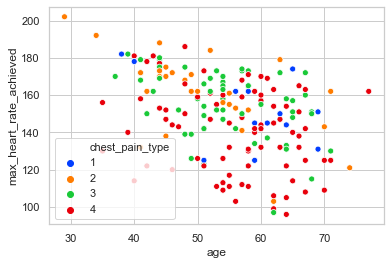

In [42]:
palette = sns.color_palette("bright", 4)
sns.scatterplot(x = 'age', y = 'max_heart_rate_achieved', 
                data = train, hue = train['chest_pain_type'], palette = palette);

As expected, there is a negative relationship between age and max heart rate achieved but they dont seem to correlate with chest pain type. Chest pain types seem to be relatively uniform. 

chest_pain_type
1    57.846154
2    50.821429
3    54.315789
4    56.036585
Name: age, dtype: float64


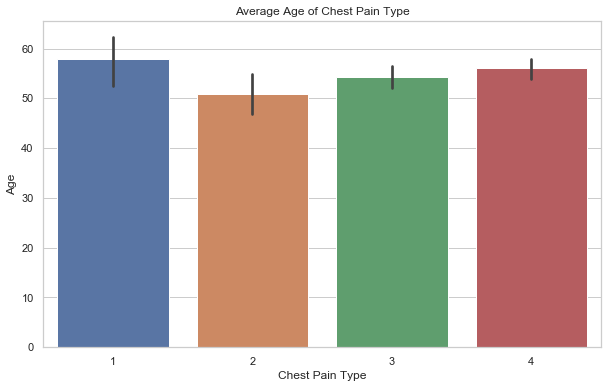

In [43]:
plt.figure(figsize = (10,6))
print(train.groupby('chest_pain_type')['age'].mean())
sns.barplot(x = train.chest_pain_type, y = train.age)
plt.title("Average Age of Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Age");

F_onewayResult(statistic=2.767207747398542, pvalue=0.04330865490718395)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.767
Date:                Fri, 25 Oct 2019   Prob (F-statistic):             0.0433
Time:                        14:52:38   Log-Likelihood:                -652.83
No. Observations:                 180   AIC:                             1314.
Df Residuals:                     176   BIC:                             1326.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  57.8462      2.551     22.672      0.000      52.811      62.882
C(chest_pain_type)[T.2]    -7.0247      3.087     -2.275      0.024     -13.118      -0.931
C(chest_pain_type)[T.3]    -3.5304      2.828     -1.249      0.213      -9.111       2.050
C(chest_pain_type)[T.4]    -1.8096      2.746     -0.659      0.511      -7.229       3.610
==============================================================================
Omnibus:                        1.571   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.543
Skew:                          -0.141   Prob(JB):                        0.462
Kurtosis:                       2.645   Cond. No.                         8.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

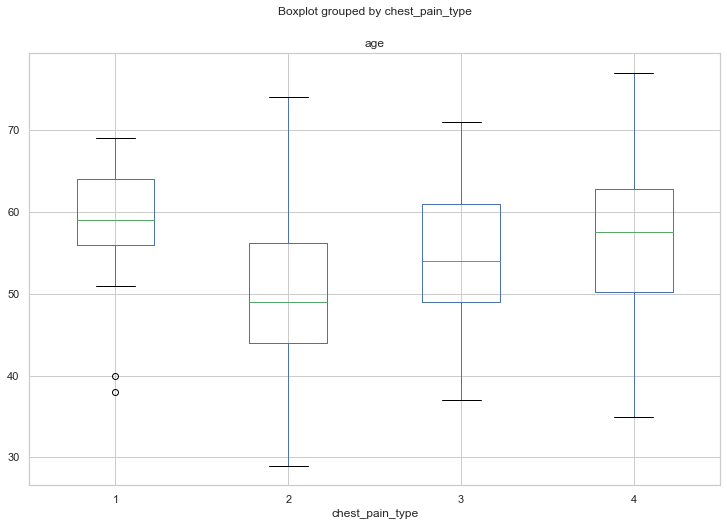

In [62]:
train.boxplot('age', by = 'chest_pain_type', figsize = (12,8))
stats.f_oneway(train['age'][train['chest_pain_type'] == 1],
                     train['age'][train['chest_pain_type'] == 2],
                     train['age'][train['chest_pain_type'] == 3],
                     train['age'][train['chest_pain_type'] == 4])

anova_test = smf.ols('age ~ C(chest_pain_type)', data = train).fit()
anova_test.summary()


The bar plot comparing the average ages per each chest pain type furthers my suspicions. 
There does not seem to be a significant difference in average ages between the types of chest pain. 
The boxplots and an Analysis of Variance test seem to suggest otherwise. 
The boxplot shows there is a difference in variance between the types of pain but their average is similar.
The ANOVA test rejects the null hypothesis of there being no difference between groups with a p value of 0.0433,
suggesting there is a difference in ages between the chest pains, but the effect size implies the 
difference is negligible.

In [45]:
#cpt1 = train[train.chest_pain_type == 1]
#cpt2 = train[train.chest_pain_type == 2]
#cpt3 = train[train.chest_pain_type == 3]
#cpt4 = train[train.chest_pain_type == 4]

#trace1 = go.Scatter(
#                    x = cpt1.age, y = cpt1.max_heart_rate_achieved,
#                    mode = 'markers', name = 'Chest Pain Type 1', 
#                    marker = dict(color = 'rgba(255, 0, 0, 0.8)') )
    
#trace2 = go.Scatter(
#                    x = cpt2.age, y = cpt2.max_heart_rate_achieved,
#                    mode = 'markers', name = 'Chest Pain Type 2', 
#                    marker = dict(color = 'rgba(0, 200, 0, 0.8)') )
    
#trace3 = go.Scatter(
#                    x = cpt3.age, y = cpt3.max_heart_rate_achieved,
#                    mode = 'markers', name = 'Chest Pain Type 3', 
#                    marker = dict(color = 'rgba(0, 0, 255, 0.8)') )
    
#trace4 = go.Scatter(
#                    x = cpt4.age, y = cpt4.max_heart_rate_achieved,
#                    mode = 'markers', name = 'Chest Pain Type 4', 
#                    marker = dict(color = 'rgba(0, 0, 0, 0.8)') )
    
#data = [trace1, trace2, trace3, trace4]
    
#layout = dict(title = 'Age vs Max HR Achieved with Chest Pain Types',
#                 xaxis = dict(title = "Age", ticklen = 5, zeroline = False),
#                 yaxis = dict(title = "Max HR Achieved", ticklen = 5, zeroline = False))

#fig = dict(data = data, layout = layout)
#plotly.offline.plot(fig, filename = "Age_vs_MaxHR.html")

# Analysis of the Response Variable (Presence of Heart Disease)

## Heart Disease Presence vs Age

Inlcude because older people tend to have heart disease. 

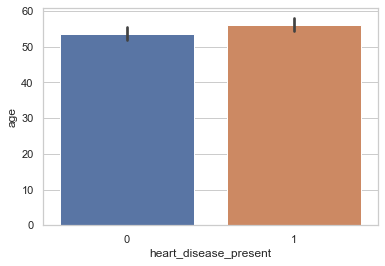

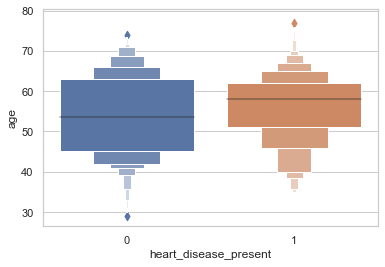

In [139]:
sns.barplot(x = y.heart_disease_present, y = train.age)
plt.show()
sns.boxenplot(x = y.heart_disease_present, y = train.age)
plt.show()

In [47]:
#Anova test of heart disease vs age
anova_test = smf.ols('heart_disease_present ~ age', data = data).fit()
anova_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     heart_disease_present   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.014
Method:                    Least Squares   F-statistic:                     3.469
Date:                   Fri, 25 Oct 2019   Prob (F-statistic):             0.0642
Time:                           14:21:58   Log-Likelihood:                -127.79
No. Observations:                    180   AIC:                             259.6
Df Residuals:                        178   BIC:                             266.0
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0399      0.220      0.181      0.856      -0.395       0.475
age            0.0074      0.004      1.862      0.064      -0.000       0.015
==============================================================================
Omnibus:                     1139.120   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.750
Skew:                           0.211   Prob(JB):                     9.42e-07
Kurtosis:                       1.123   Cond. No.                         332.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There does not seem to be any major difference in ages between the age ranges of the people who did have 
some form of heat disease versus the people who did not. The boxplot shows the variability of the people
who did have it was less, which is reasonable. One would expect heart disease to occur more often in the 
older population than in the younger group. The bargraph also hints at this since it shows the mean 
patients having heart disease is slightly higher. An analysis of variance test between the two groups suggests there might be a small difference between the ages of the two groups. Will include in model to be safe.

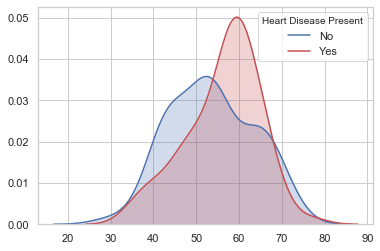

In [48]:
sns.kdeplot(data.age[data.heart_disease_present == 0], shade = True)
sns.kdeplot(data.age[data.heart_disease_present == 1], shade = True, color = "r")
plt.legend(title = 'Heart Disease Present', labels = ['No', "Yes"])

## Heart Disease Presence vs Sex

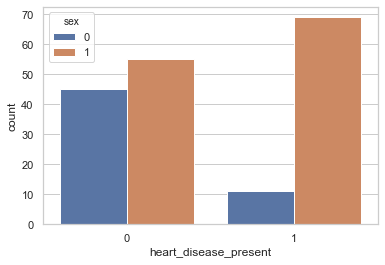

In [49]:
data.groupby("heart_disease_present")['sex'].value_counts()

sns.countplot(x = "heart_disease_present", data = data, hue = "sex") 

anova_test = smf.ols('heart_disease_present ~ C(sex)', data = data).fit()
anova_test.summary()
data['sex'].value_counts();

There does seem to be a relationship between the sex of a patient and whether there is heart disease present. Males tend to be at higher risk of developing some form of heart disease. Since there are significantly more males than females in the study, it is better to look at their corresponding proportions. 

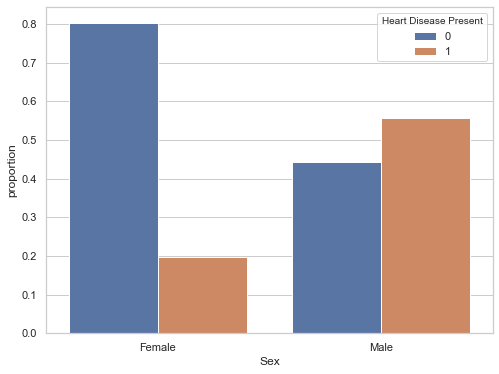

In [50]:
# create a table summarizing the counts in sexes vs heart disease
hd_sex = data[['sex', 'heart_disease_present']]
hd_vs_sex = pd.crosstab(hd_sex.sex, hd_sex.heart_disease_present)

# divided the values by their respective sex total to find the proportions
hd_vs_sex_norm = pd.crosstab(hd_sex.sex, hd_sex.heart_disease_present, 
                       normalize = 'index')
hd_vs_sex_norm


# spread out data to plot
hd_vs_sex_norm = hd_vs_sex_norm.reset_index()
hd_vs_sex_norm_spread = pd.melt(hd_vs_sex_norm, id_vars = 'sex', var_name = 'heart_disease_present', value_name = 'proportion')
hd_vs_sex_norm_spread['sex'].replace(0, "Female", inplace = True)
hd_vs_sex_norm_spread['sex'].replace(1, "Male", inplace = True)

plt.figure(figsize = (8,6))
g = sns.barplot(x = 'sex', y = 'proportion', data = hd_vs_sex_norm_spread, hue = "heart_disease_present") 
plt.xlabel("Sex")
plt.legend(title = "Heart Disease Present")
plt.show(g);

As suggested, males on average are more likely to develop heart disease, while females are significantly less likely. 80% of women do not have a form of disease while 56% of men do. I wonder why there is a large discrepancy, might be worth investigating.

###### Investigating the cause for Sex's effect on Heart Disease
(pending)

##  Heart Disease Presence vs Maximum Heart Rate Achieved

Even though the result seems trivial, I want to see if there is a difference in maximum heart rates achieched between the patiens who did and did not have heart disease. I expect to find that people with heart disease will not be able to acheive as high of a heart rate as people with healthy hearts since theirs is weakened. 

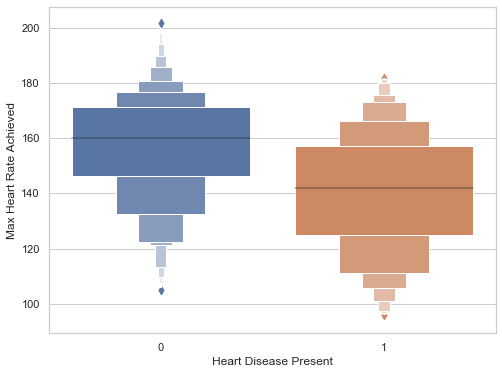

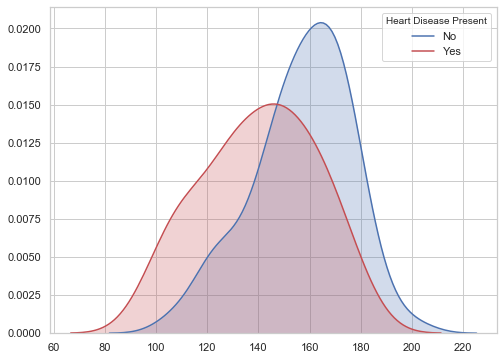

In [51]:
#boxplot of max HR grouped by prescence of heart disease
plt.figure(figsize = (8,6))
sns.boxenplot(x = data.heart_disease_present, y = data.max_heart_rate_achieved)
plt.xlabel("Heart Disease Present")
plt.ylabel("Max Heart Rate Achieved")
plt.show()

#kernel density estimate plot
plt.figure(figsize = (8,6))
sns.kdeplot(data.max_heart_rate_achieved[data.heart_disease_present == 0], shade = True, legend = True)
sns.kdeplot(data.max_heart_rate_achieved[data.heart_disease_present == 1], shade = True, color = "r", legend = True)
plt.legend(title = "Heart Disease Present", labels = ["No", "Yes"])
plt.show()

#ANOVA test to determine difference
HR_vs_HD_test = smf.ols("heart_disease_present ~ max_heart_rate_achieved", data = data).fit()
HR_vs_HD_test.summary();

My hypothesis seems to be correct. Patients with heart disease tend to achieve a lower maximum heart rate. The box plot and the kernel estimate plot show the distribution for the people with heart disease to be lower than the ones without. The ANOVA test confirms the visuals. There is a difference between the two groups, rejecting the hypthesis of the groups being similar with a p-value of $2.08 \times 10^{-7}$. Nothing particularly suprising here. 

## Heart Disease Presence vs Type of Chest Pain 

If the heart is weakened by some form of heart disease, I would expect there to be some for of discomfort or pain in the chest. Thus, I expect more individuals with heart disease to have more serious forms of chest pains. 

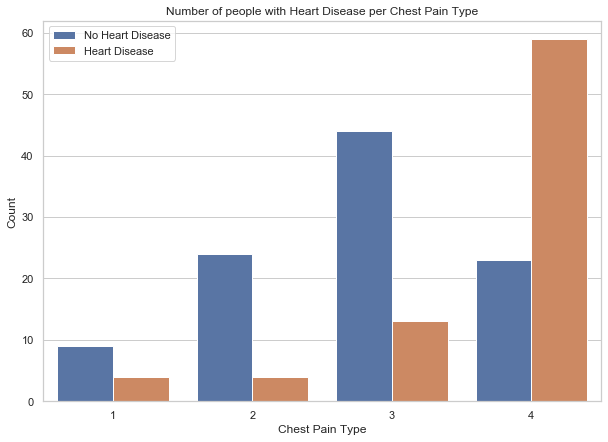

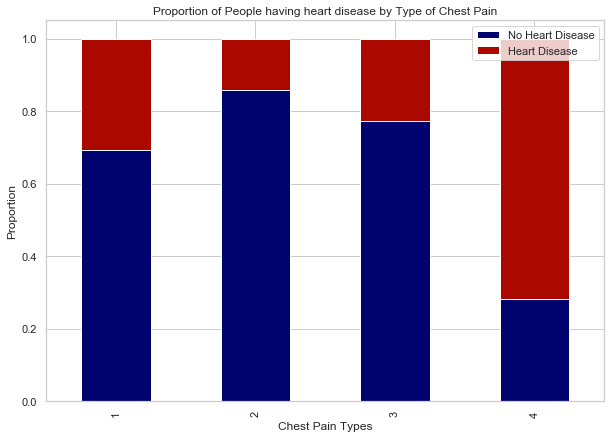

In [52]:
#bar plot displaying the counts for each chest pain type grouped by whther they had heart disease 
fig, ax = plt.subplots(figsize=(10,7))  

sns.countplot(x = data.chest_pain_type, hue = data.heart_disease_present)
plt.title("Number of people with Heart Disease per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")
ax.legend(labels = ["No Heart Disease", "Heart Disease"])
plt.show()


#Prepare data by normalizing before creating stacked barplot
pivot_df = pd.crosstab(data.chest_pain_type, data.heart_disease_present, normalize = "index")
pivot_df = pivot_df.reset_index()
pivot_df = pd.melt(pivot_df, id_vars = "chest_pain_type", var_name= "heart_disease_present", value_name = "proportion")



#stacked bar plot displaying the proportion of people having heart disease per chest pain type
fig, ax = plt.subplots(figsize=(10,7))  

hd = pivot_df["heart_disease_present"].drop_duplicates()
margin_bottom = np.zeros(len(pivot_df.chest_pain_type.drop_duplicates()))
colors = ["#00026d", "#ab0900"]

for i, hd_prsnt in enumerate(hd):
    proportion = list(pivot_df[pivot_df["heart_disease_present"] == hd_prsnt].loc[:,"proportion"])
    pivot_df[pivot_df["heart_disease_present"] == hd_prsnt].plot.bar(x = "chest_pain_type", y = "proportion",
                                                                    ax = ax, stacked = True, color = colors[i],
                                                                    bottom = margin_bottom, label = hd_prsnt)
    margin_bottom += proportion
    
mylabels = ["No Heart Disease", "Heart Disease"]
ax.legend(labels = mylabels)
plt.xlabel("Chest Pain Types")
plt.ylabel("Proportion")
plt.title("Proportion of People having heart disease by Type of Chest Pain")
plt.show();

According to the data, my hypothesis was incorrect, extremely incorrect at that. Apparently, more people with no heart disease tend to have some form of chest pain (types 1, 2, and 3). Meanwhile, most of the people with chest pain type 4 (asymptom) tend to have heart disease. This is wildly against my expectations. Requires further investigation. There may be some interacting term that explains the discrepancy. 

###### Investigating why Heart disease is not associating with chest pain
(pending)

## Heart Disease Presence vs Exercise Induced Angina

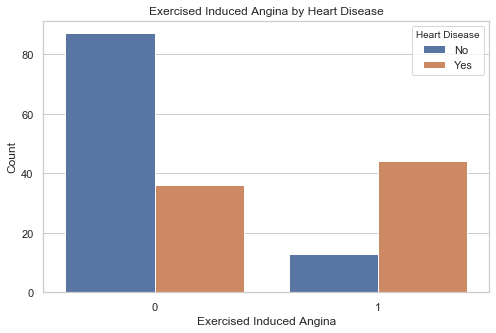

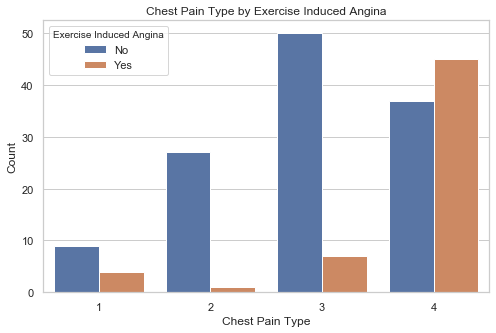

In [53]:
plt.figure(figsize = (8,5))
sns.countplot(x = data.exercise_induced_angina, hue = data.heart_disease_present)
plt.title("Exercised Induced Angina by Heart Disease")
plt.xlabel("Exercised Induced Angina")
plt.ylabel("Count")
plt.legend(title = "Heart Disease", labels = ["No", "Yes"])
plt.show()


plt.figure(figsize = (8,5))
g = sns.countplot(x = data.chest_pain_type, hue = data.exercise_induced_angina)
plt.title("Chest Pain Type by Exercise Induced Angina")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")
plt.legend(title = "Exercise Induced Angina", labels = ["No", "Yes"])
plt.show();


Heart disease does seem to be related to exercise induced angina. People who have heart disease tend to be more likely to have exercise induced angina, which makes sense. Out of curiousity, I looked into how exercise induced angina related to the type of chest pain. Since it is a type of angina (though caused by exercise), I expected it to be correlated with chest pain types 1 and 2 which are types of angina, typical and atypical respectively). That is not the case. Exercise induced angina occurs more in people with chest pain type 4, asymptom, falling inline with the previous findings. It does hint at not needing one of the two vairables, EIA and CPT, in the eventual model that will be trained on the data.

## Heart Disease vs Old peak ST Depression

ST depression occurs when the ST segment, a section of electrocardiogram readings, falls bellow the baseline. This is often a sign of myocardial ischaemia which is caused by ischemic heart disease. Knowing this, I expect to find a correlation between the old peak ST depression variable and heart disease. 

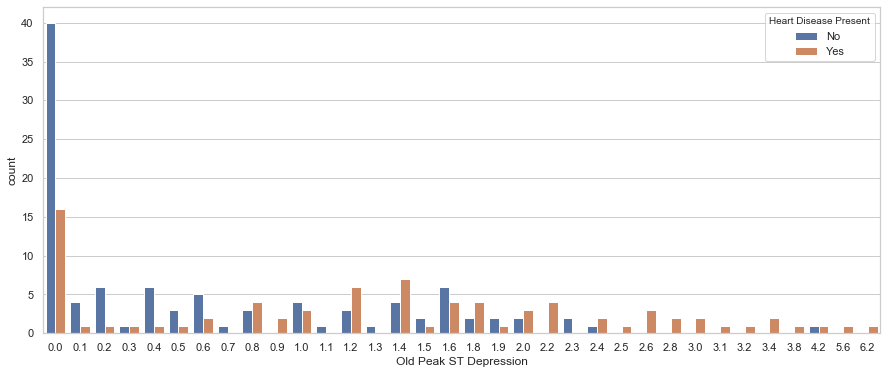

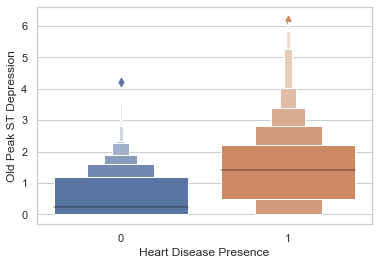

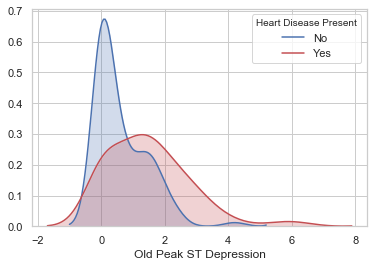

In [54]:
plt.figure(figsize = (15,6))
sns.countplot(data.oldpeak_eq_st_depression, hue = data.heart_disease_present)
plt.legend(title = "Heart Disease Present", labels = ["No", "Yes"], loc = "upper right");
plt.xlabel("Old Peak ST Depression")
plt.show()

sns.boxenplot(data.heart_disease_present, data.oldpeak_eq_st_depression)
plt.xlabel("Heart Disease Presence")
plt.ylabel("Old Peak ST Depression")
plt.show()


sns.kdeplot(data.oldpeak_eq_st_depression[data.heart_disease_present == 0], shade = True)
sns.kdeplot(data.oldpeak_eq_st_depression[data.heart_disease_present == 1], shade = True, color = "r")
plt.xlabel("Old Peak ST Depression")
plt.legend(title = "Heart Disease Present", labels = ["No", "Yes"])
plt.show();

Indeed my hypothesis was correct. Higher ST Depression peak are correlated with the presence of heart disease; meaning as the peak increases, the number of patients having heart disease increases and vice versa. Moreover, we can see the distribution of the ST depression of the patients with heart disease is more variable and skews right, reaching higher values more consistently. 

## Heart Disease vs Resting Blood Pressure

Looking at the distributions, there does not seem to be much of a difference in the resting blood pressures of patients with heart disease and those without. Welch's t-test fails to reject the statistical hypothesis of patients with and without blood pressure having similar resting blood pressure values. Additionally, an F-test fails to reject the hypothesis of the two groups having similar variance. 

Oddly, this goes against my expectation. I expected people with heart disease to have some form of bloackage in their arteries and thus having a higher resting blood pressure. Since there is no discernible difference, the variable may not be needed in the model.

Interestingly, the majority of people seem to have either elevated blood pressure or are hypertensive according to new American Heart Association guidelines. A normal blood pressure below 120 is considered normal. Americans are really unhealthy, generally.

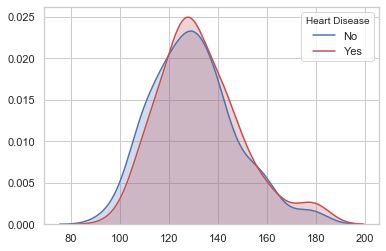

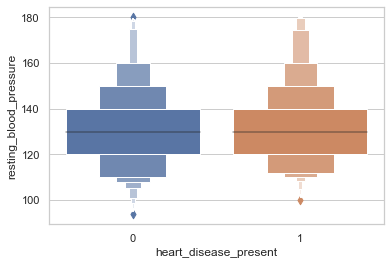

Ttest_indResult(statistic=-1.0511621959574544, pvalue=0.29467822809908845)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     heart_disease_present   R-squared:                       0.006
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.104
Date:                   Fri, 25 Oct 2019   Prob (F-statistic):              0.295
Time:                           14:22:07   Log-Likelihood:                -128.97
No. Observations:                    180   AIC:                             261.9
Df Residuals:                        178   BIC:                             268.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1425      0.290      0.492      0.624      -0.429       0.714
resting_blood_pressure     0.0023      0.002      1.051      0.295      -0.002       0.007
==============================================================================
Omnibus:                     1084.032   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.295
Skew:                           0.221   Prob(JB):                     4.35e-07
Kurtosis:                       1.074   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ttest_1sampResult(statistic=8.921253662268073, pvalue=5.337377677013746e-16)

In [55]:
sns.kdeplot(data.resting_blood_pressure[data.heart_disease_present == 0], shade = True)
sns.kdeplot(data.resting_blood_pressure[data.heart_disease_present == 1], shade = True, color = "r")
plt.legend(title = "Heart Disease", labels = ["No", "Yes"])
plt.show()

sns.boxenplot(data.heart_disease_present, data.resting_blood_pressure)
plt.show();

stats.ttest_ind(data.resting_blood_pressure[data.heart_disease_present == 0],
                data.resting_blood_pressure[data.heart_disease_present == 1], equal_var=False)

anova_test = smf.ols('heart_disease_present ~ resting_blood_pressure', data = data).fit()
anova_test.summary()


stats.ttest_1samp(data.resting_blood_pressure, 120)

In [63]:
#vars_2_c = ['sex', 'age', 'max_heart_rate_achieved', 'chest_pain_type', 'serum_cholesterol_mg_per_dl', 'resting_blood_pressure']
#plt.figure(figsize = (14, 14))
#sns.pairplot(data, hue = 'heart_disease_present', vars = vars_2_c);

## Heart Disease vs Thal

thal's barplot sindicates it could be a good predictor because of the variability of people in each thal category that have heart disease.

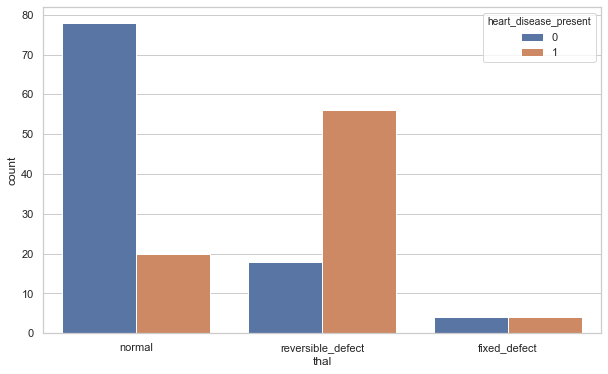

In [72]:
plt.figure(figsize = (10,6))
sns.countplot(data.thal, hue = data.heart_disease_present);

## Heart Disease vs Number of Major Blood Vessels

Huge difference between people with heart disease and people without. People with heart disease vary significantly more in the number of major blood vessels colored by flouroscopy. **Definitely should be included**

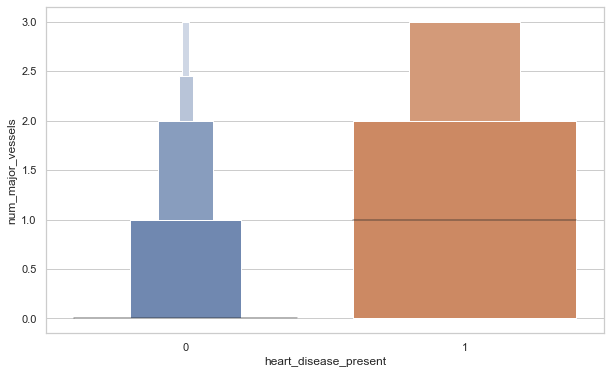

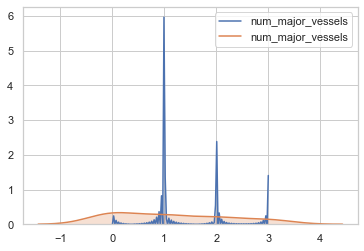

In [81]:
plt.figure(figsize = (10,6))
sns.boxenplot(data.heart_disease_present, data.num_major_vessels)
plt.show()
sns.kdeplot(data.num_major_vessels[data.heart_disease_present == 0], shade = True)
sns.kdeplot(data.num_major_vessels[data.heart_disease_present == 1], shade = True);

## Heart Disease vs slope_of_peak_exercise_st_segment

Looks like it could be a good predictor.

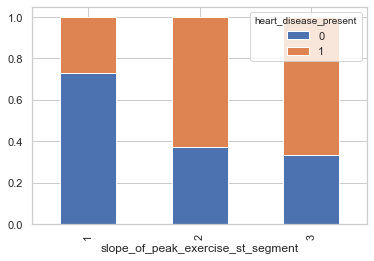

In [102]:
table = pd.crosstab(data.slope_of_peak_exercise_st_segment, data.heart_disease_present, normalize="index")
#table.plot(kind = "bar")
table.plot(kind = "bar", stacked = True);

## Heart Disease vs fasting_blood_sugar_gt_120_mg_per_dl 

Looked like it was border line useful initially but after normalizing and looking at a stacked barplot, there doesnt seem to be a difference whther or not the fasting blood sugar levels were above 120 mg/dl. **Not useful**

heart_disease_present,0,1
fasting_blood_sugar_gt_120_mg_per_dl,,
0,0.556291,0.443709
1,0.551724,0.448276


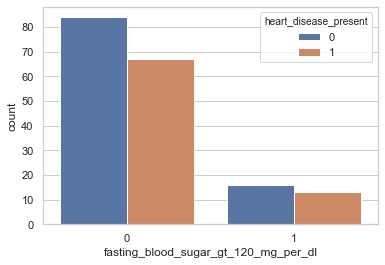

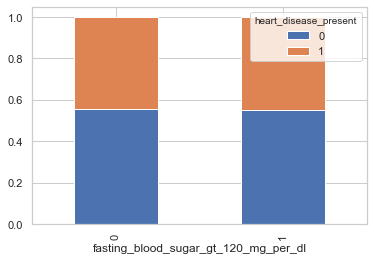

In [122]:
table = pd.crosstab(data.fasting_blood_sugar_gt_120_mg_per_dl, data.heart_disease_present, normalize="index")
table
sns.countplot(data.fasting_blood_sugar_gt_120_mg_per_dl, hue = data.heart_disease_present)
plt.show()
table.plot(kind = "bar", stacked = True)

## Heart Disease vs resting_ekg_results 

Theres not much of a difference between groups. Even though the proportion of people with resting_ekg_results of 2 is 100% for having heart disease, there is only one person in the group making it not very significant. Across the other 2 groups, there is a little bit of a difference, may be worth including anyways. 
**Borderline**

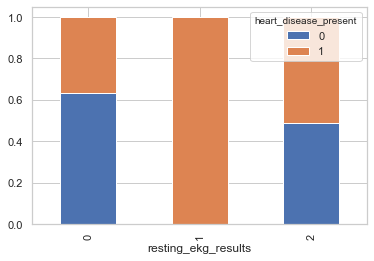

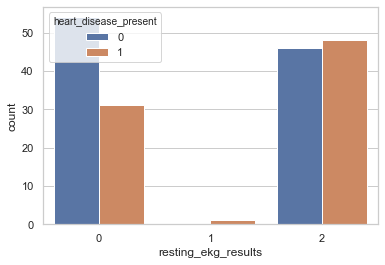

In [130]:
table = pd.crosstab(data.resting_ekg_results, data.heart_disease_present, normalize="index")
table.plot(kind = "bar", stacked = True)
plt.show()
sns.countplot(data.resting_ekg_results, hue  = data.heart_disease_present)

## Heart Disease vs serum_cholesterol_mg_per_dl 

Not much of a difference. Will exclude to make the model simpler **No Bueno**

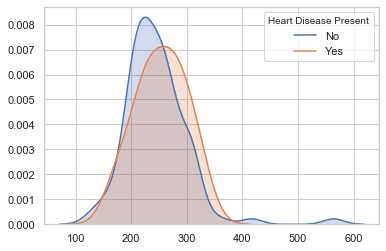

In [136]:
sns.kdeplot(data.serum_cholesterol_mg_per_dl[data.heart_disease_present == 0], shade = True);
sns.kdeplot(data.serum_cholesterol_mg_per_dl[data.heart_disease_present == 1], shade = True);
plt.legend(title = "Heart Disease Present", labels = ["No", "Yes"]);

In [59]:
# wanted to create a funciton but gets a little messy. would rather do a pipe for both cat and num columns but also 
# more complicated than it needs to be since it strips variable names

#def cat_transformer(X_cat):
#    cat_names = list(X_cat.columns)
#     onehot = OneHotEncoder()
#     X_cat_onehot = onehot.fit_transform(X_cat)
#     X_cat_onehot = pd.DataFrame(X_cat_onehot.toarray())
#     col_names = onehot.get_feature_names(cat_names)
#     col_names_list = list(col_names)
#     X_cat_onehot.columns = col_names_list
#     return X_cat_onehot
